In [6]:

import numpy as np
import matplotlib.pyplot as plt
import pickle
import cv2
from IPython.core.debugger import set_trace

plt.rcParams['figure.figsize'] = (12., 8.)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# 2D konvoluce pro obrázky

Nejprve si načteme nějaký testovací obrázek. Knihovna `pillow` (`PIL`) to ve spolupráci s balíkem `requests` umí i z URL.

In [3]:
import PIL
import requests

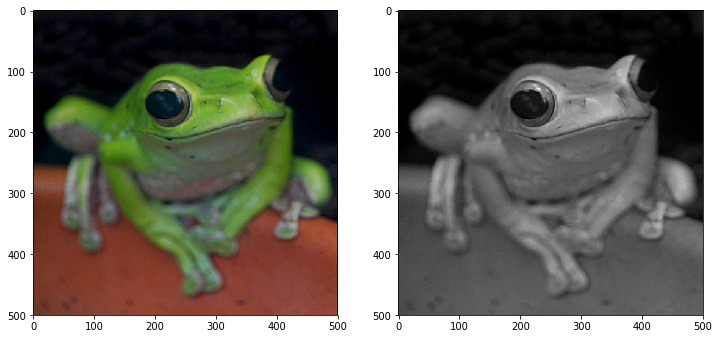

In [7]:
url = 'https://camo.githubusercontent.com/7e8b7ea66e6dbc2fbcd72bc2a105ed464de1b6b1/687474703a2f2f6661726d352e737461746963666c69636b722e636f6d2f343037302f343731373336333934355f623733616664373861392e6a7067'
img = PIL.Image.open(requests.get(url, stream=True).raw)
rgb_test = np.array(img, dtype=np.float32) / 255.
gray_test = cv2.cvtColor(rgb_test, cv2.COLOR_RGB2GRAY)

plt.subplot(1, 2, 1)
plt.imshow(rgb_test)
plt.subplot(1, 2, 2)
plt.imshow(gray_test)
plt.show()

Konvoluce má dva operandy: zdrojový signál (orbázek) a jádro (kernel) konvoluce, často označované také jako konvoluční filtr. Oba operandy si musí odpovídat svými rozměry. Pokud budeme uvažovat šedotónový obrázek reprezentovaný 2D maticí, filtr bude rovněž matice. RGB obrázky reprezentované 3D maticí $H × W × C$ budou konvolvovány s rovněž 3D filtrem o rozměrech $H' × W' × C$.

Vyzkoušíme si dva typy filtrů řešící úlohu detekce hran Sobelovým filtrem a filtrace šumu pomocí průměrování.

In [8]:
W_sobel_x = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1],
])

W_sobel_y = np.array([
    [ 1,  2,  1],
    [ 0,  0,  0],
    [-1, -2, -1],
])

W_blur = 1. / 81. * np.ones((9, 9))

## Konvoluce ve scipy

Konvoluce v balíku `scipy.signal` bohužel zvládá pouze čistě 2D konvoluci, tzn. že jak obrázek, tak filtr musí být dvourozměrnhé matice. RGB orbázky nejsou podporovány a konvoluce tak musí být provedena pro každý kanál zvlášť. To zní jako příliš práce, a tak si zde ukážeme pouze podporovanou variantu.

In [9]:
from scipy import signal

Následující kód projede všechny filtry, provede jejich konvoluci se vstupním obrázkem a výsledek zobrazí. Dělení 255 je zde kvůli převedení do rozsahu 0...1 a přetypování na `float`, aby nedocházelo k přetýkání.

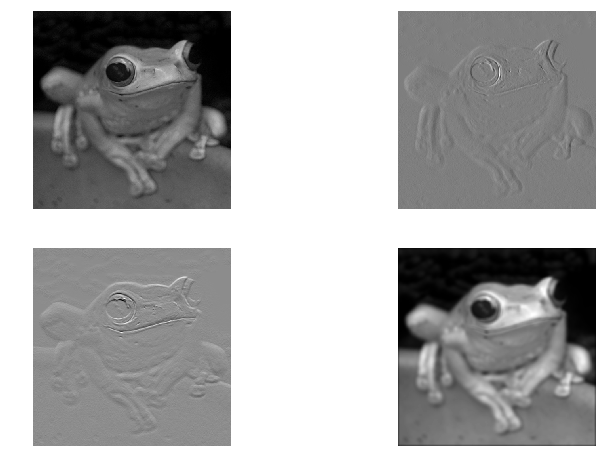

In [10]:
for i, kernel in enumerate((None, W_sobel_x, W_sobel_y, W_blur)):
    if kernel is None:
        # neni filtr --> neprovadej konvoluci = zobrazi se nezmeneny obrazek
        out = gray_test
    else:
        # `mode='same'` --> vystup bude mit stejny rozmer jako vstup
        # `boundary='fill', fillvalue=0.` --> tzv. zero padding, tj. nastavi obrazek nulami
        out = signal.convolve2d(gray_test, kernel, mode='same', boundary='fill', fillvalue=0.)
    plt.subplot(2, 2, i + 1)
    plt.imshow(out)
    plt.axis('off')
plt.show()

Všimněme si, jaký rozměr má výstup konvoluce:

In [11]:
print(gray_test.shape)
print(out.shape)

(500, 500)
(500, 500)


## Konvoluce v OpenCV

Populární knihovna OpenCV implementuje 2D konvoluci funkcí `cv2.filter2D`, která na rozdíl od `scipy.signal.convolve2d` podporuje i RGB obrázky. Pokud jako vstup zadáme RGB obrázek, tedy 3D matici, a 2D filtr, stane se přesně to, co bychom při použití `scipy.signal.convolve2d` museli dělat ručně, tj. konvoluce se provede pro každý kanál zvlášť.

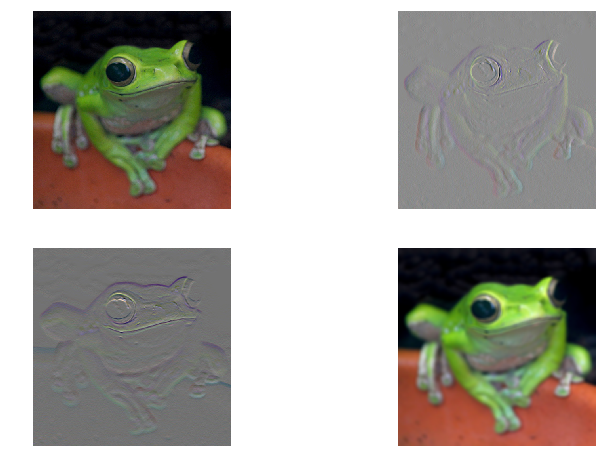

In [12]:
for i, kernel in enumerate((None, W_sobel_x, W_sobel_y, W_blur)):
    if kernel is None:
        # neni filtr --> neprovadej konvoluci = zobrazi se nezmeneny obrazek
        out = rgb_test
    else:
        # defaultne ma vystup z `cv2.filter2D` stejne rozmery jako vstup
        out = cv2.filter2D(rgb_test, -1, kernel)
    plt.subplot(2, 2, i + 1)
    plt.imshow((out - out.min()) / (out.max() - out.min() + 1e-6))
    plt.axis('off')
plt.show()

Opět zkontrolujeme velikost výstupu:

In [13]:
print(rgb_test.shape)
print(out.shape)

(500, 500, 3)
(500, 500, 3)


# Konvoluce v PyTorch

In [14]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

Konvoluce v PyTorch je o něco obtížnější, protože framework je primárně určen pro učení neuronových sítí, ne k práci s obrázky. Vše je uzpůsobeno pro trénování metodou minibatch SGD, což znamená, že PyTorch očekává 4D vstup formátu `(dávka, kanály, výška, šířka)`. Pokud tedy chceme provést konvoluci s šedotónovým 2D obrázkem `gray_test`, musíme přidat dvě dimenze navíc. Kromě toho funkce pracují nad PyTorch tensory, nikoliv numpy poli, a je tedy nutná i konverze.

In [15]:
x = gray_test
x = torch.from_numpy(x[None, None])
x.shape

torch.Size([1, 1, 500, 500])

S filtrem je to také obtížnější. Ten musí být formátu `(výstupní kanály, vstupní kanály, filtr výška, filtr šířka)`. Opět tedy musíme kernel trochu upravit.

In [16]:
w = W_sobel_x[None, None]
w = torch.from_numpy(w).float()
w.shape

torch.Size([1, 1, 3, 3])

PyTorch definuje většinu operací v modulu `torch.nn.functional`, které pak obaluje vrstvami definovanými v modulu `torch.nn`. Pokud nechceme vytvářet vrstvu, ale pouze provést konvoluci nějakého vstupu a nějakého filtru, zavoláme funkci `conv2d`. Ta navíc vyžaduje, aby oba operandy byly typu `torch.autograd.Variable` a funkce tak mohla pracovat s dynamickým výpočetním grafem pro případný zpětný průchod.

In [17]:
# padding=1 --> hodnota 1 je zaokrouhlena polovina velikosti filtru --> zachova se velikost vstupu
z = F.conv2d(Variable(x), Variable(w), padding=1)

In [18]:
print(x.shape)
print(z.shape)

torch.Size([1, 1, 500, 500])
torch.Size([1, 1, 500, 500])


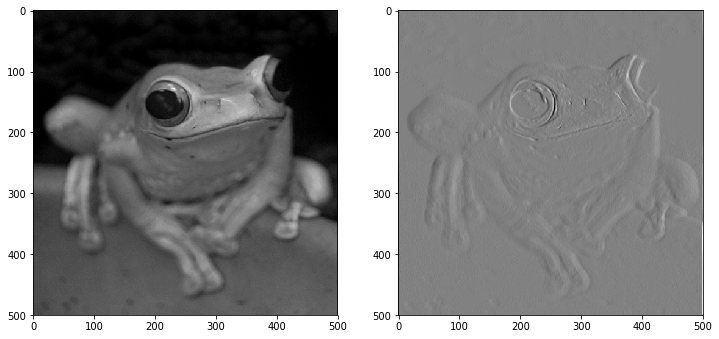

In [19]:
plt.subplot(1, 2, 1)
plt.imshow(gray_test)
plt.subplot(1, 2, 2)
plt.imshow(z.data.numpy()[0, 0, :, :])
plt.show()

## Konvoluce RGB obrázku

Vyzkoušíme si i 2D konvoluci RGB obrázku, která se chová jinak, než co jsme doposud zkoušeli. V PyTorch je 2D konvouce vícekanálových obrázků v podstatě 3D konvoluce s filtrem, který má v třetím rozměru odpovídajícímu kanálům stejnou velikost jako vstup (zatímco v $xy$ je např. $3×3$, přičemž obrázek např. $640×480$). Tedy např. pokud má obrázek 3 kanály, pak i filtr musí mít 3 kanály.

Vstup tentokrát bude RGB. Připomeňme si, že v PyTorch je RGB obrázek reprezentován ve formátu `(kanály, výška, šířka)`.

In [20]:
x = rgb_test
x = x.transpose(2, 0, 1)
x = torch.from_numpy(x[None])
x.shape

torch.Size([1, 3, 500, 500])

Pokud je vstup RGB, tedy 3D, pak i filtr musí být 3D.

In [21]:
w = np.stack((W_sobel_x, W_sobel_x, W_sobel_x))[None]
w = torch.from_numpy(w).float()
w.shape

torch.Size([1, 3, 3, 3])

In [22]:
# padding=1 --> hodnota 1 je zaokrouhlena polovina velikosti filtru --> zachova se velikost vstupu
z = F.conv2d(Variable(x), Variable(w), padding=1)

In [23]:
print(x.shape)
print(z.shape)

torch.Size([1, 3, 500, 500])
torch.Size([1, 1, 500, 500])


Všimněme si, že výstup má pouze jeden kanál! To proto, že nedochází k sumaci pouze v $x$ a $y$, ale i v kanálech. A jelikož provádíme konvoluci pouze jedním Sobelovým filtrem, výstup má pouze jeden kanál.

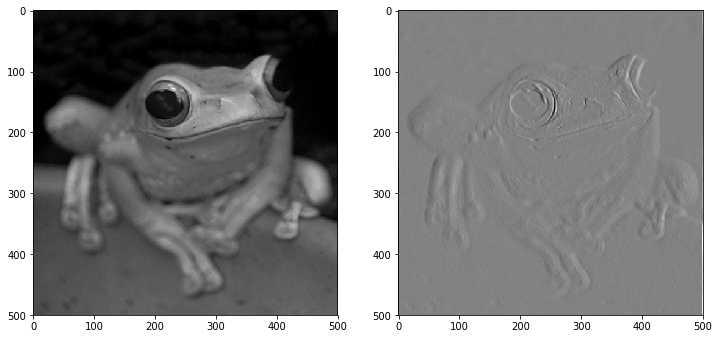

In [24]:
plt.subplot(1, 2, 1)
plt.imshow(gray_test)
plt.subplot(1, 2, 2)
plt.imshow(z.data.numpy()[0, 0, :, :])
plt.show()

## Konvoluce po jednotlivých kanálech

Jako cvičení k pochopení konvoluce nyní máte za úkol napodobit chování OpenCV, tj. udělat konvoluci RGB obrázku po jednotlivých kanálech.

In [215]:
out = np.zeros_like(rgb_test)
chanels = [rgb_test[:,:,0], rgb_test[:,:,1], rgb_test[:,:,2]]
chanelsOut = np.zeros_like(rgb_test[:,:,0])
for k in range(0,3):
    ch = rgb_test[:,:,k]
    chSize = ch.shape
    ch = np.vstack([ch, np.zeros(chSize[0])])
    ch = np.vstack([ np.zeros(chSize[0]), ch])
    
    ch = np.column_stack((ch, np.zeros(chSize[1]+2)))
    ch = np.column_stack((np.zeros(chSize[1]+2), ch))
    for i in range(1, chSize[0]):
        for j in range(1, chSize[1]):
            out[i,j,k] = np.sum(ch[i-1:i+2, j-1:j+2] * W_sobel_y)
    
    







In [214]:
#test Fce
A = [[1, 1 ],[2, 2 ]]
A = np.vstack([A, [0, 0]])
A = np.vstack([ [0, 0],A])
print(A)
A = np.column_stack((A, [0,0,0,0]))
A = np.column_stack(([0,0,0,0],A))
print(A)

E = np.array([[1,2,3,4], [1,2,3,4], [1,2,3,4],[1,2,3,4]])


for i in range(1, 3):
        for j in range(1, 3):
            print(E[i-2:i+1, j-2:j+1])

[[0 0]
 [1 1]
 [2 2]
 [0 0]]
[[0 0 0 0]
 [0 1 1 0]
 [0 2 2 0]
 [0 0 0 0]]
[]
[]
[]
[[1 2 3]
 [1 2 3]
 [1 2 3]]


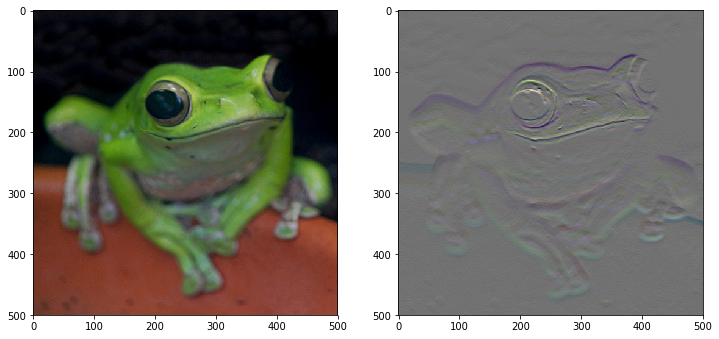

In [69]:
plt.subplot(1, 2, 1)
plt.imshow(rgb_test)
plt.subplot(1, 2, 2)
plt.imshow((out - out.min()) / (out.max() - out.min() + 1e-6))
plt.show()

## Konvoluce s více filtry najednou

Druhé cvičení bude zreplikovat v PyTorch pokus, který jsme provedli se `scipy.signal.convolve2d`. **Proveďte tedy konvoluci vstupního šedotónového 2D obrázku se všemi čtyřmi (None, W_sobel_x, W_sobel_y, W_blur) filtry najednou!** Ano, i `None` filtr (tedy bez filtrace) zapište v maticové podobě. Omezení samozřejmě je, že všechny filtry musí být stejně velké, a tedy i průměrovací filtr musí být 3x3 a nestačí tak pouze vzít matici `W_blur`.

Nesmíte tedy použít žádný for cyklus. Postup:
1. vytvoříte vstup `x`,
2. vytvoříte matici filtrů `w`,
3. zavoláte `z = F.conv2d(...)`,
4. převedete do numpy,
5. a zobrazíte jednotlivé kanály subplotem jako obvykle

In [70]:
x = rgb_test
x = x.transpose(2, 0, 1)
x = torch.from_numpy(x[None])
x.shape

torch.Size([1, 3, 500, 500])

In [71]:
W_keep = np.array(([0, 0, 0], [0, 1, 0], [0, 0, 0]))
w1 = np.stack((W_keep, W_keep, W_keep))[None]
w2 = np.stack((W_sobel_x, W_sobel_x, W_sobel_x))[None]
w3 = np.stack((W_sobel_y, W_sobel_y, W_sobel_y))[None]
W_blur2 = 1. / 9. * np.ones((3,3))
w4 = np.stack((W_blur2, W_blur2, W_blur2))[None]
w = np.concatenate((w1,w2,w3,w4))
w = torch.from_numpy(w).float()
w.shape

torch.Size([4, 3, 3, 3])

In [72]:
z = F.conv2d(Variable(x), Variable(w), padding=1)
z.shape

torch.Size([1, 4, 500, 500])

In [73]:
out = z.data.numpy().squeeze()
out.shape

(4, 500, 500)

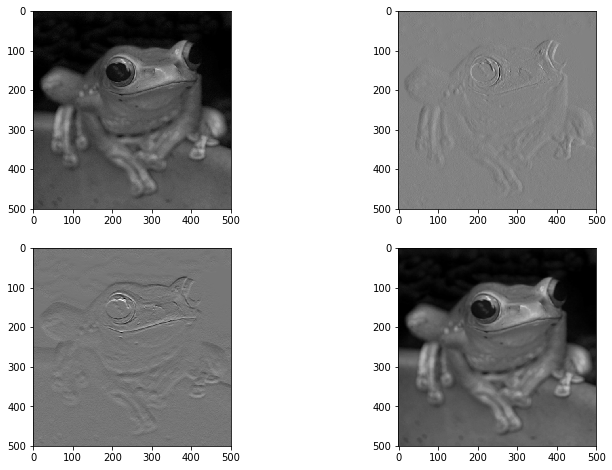

In [74]:
# pro kazdy kanal vystupu zobrazit v subplotu 2x2 jako nahore
plt.subplot(2,2,1)
plt.imshow(out[0,:,:])
plt.subplot(2,2,2)
plt.imshow(out[1,:,:])
plt.subplot(2,2,3)
plt.imshow(out[2,:,:])
plt.subplot(2,2,4)
plt.imshow(out[3,:,:])
plt.show()

## Konvoluce v PyTorch pomocí vrstvy

V PyTorch je konvoluce definována i jako vrstva, kterou reprezentuje třída `nn.Conv2d`. Ta obaluje funkci `torch.nn.functional.conv2d` tak, že si uchovává parametry `weight`, `bias` a další. V implementaci dopředného průchodu vrstvy `nn.Conv2d` najdeme:

``` python
class Conv2d(_ConvNd):
    r"""Applies a 2D convolution over an input signal composed of several input
    planes.    
    ...
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        ... inicializace apod.
    
    def forward(self, input):
        return F.conv2d(input, self.weight, self.bias, self.stride, 
            self.padding, self.dilation, self.groups
```

Podobně jsou definovány i ostatní vrstvy, jako např. lineární atd.

Konvoluční vrstvu vytvoříme jako objekt typu `nn.Conv2d`, jehož kontruktor po nás chce počet výstupních kanálů konvoluce (=počet filtrů), počet vstupních kanálů (=3 pro RGB), velikost filtru (=3 pro filtr 3x3), a zda chceme přičítat i bias.

In [136]:
conv = nn.Conv2d(3, 1, 3, padding=1, bias=False)

Jelikož PyTorch všechny vrstvy při vytvoření defaultně inicializuje, manuální nastavení vah filtru je trochu krkolomnější. Vlastní hodnoty musíme zapsat do `conv.weight.data` metodou `copy_`. Filtry alespoň nemusí mít naprosto stejné rozměry, pokud je váhová matice `conv.weight.data` 4D a `W_sobel_x` 2D, chybějící sigletony si PyTorch domyslí.

In [137]:
conv.weight.data.copy_(torch.from_numpy(W_sobel_x).float())


(0 ,0 ,.,.) = 
  1  0 -1
  2  0 -2
  1  0 -1

(0 ,1 ,.,.) = 
  1  0 -1
  2  0 -2
  1  0 -1

(0 ,2 ,.,.) = 
  1  0 -1
  2  0 -2
  1  0 -1
[torch.FloatTensor of size 1x3x3x3]

In [138]:
print(Variable(w).shape)

torch.Size([4, 3, 3, 3])


Dopředný průchod je pak už jednoduchý...

In [139]:
z = conv(Variable(x))
z.shape

torch.Size([1, 1, 500, 500])

In [140]:
out = z[:,0,:,:].data.numpy().squeeze()

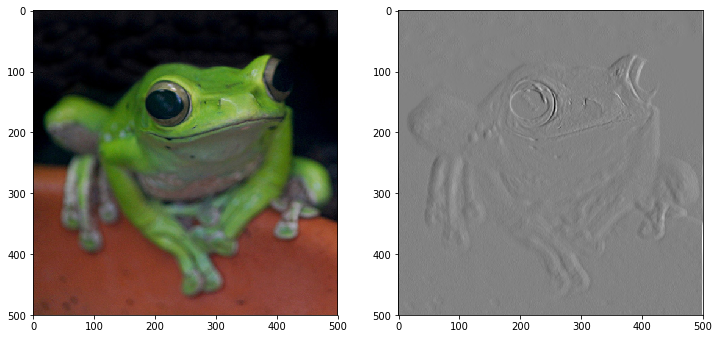

In [141]:
plt.subplot(1, 2, 1)
plt.imshow(rgb_test)
plt.subplot(1, 2, 2)
plt.imshow((out - out.min()) / (out.max() - out.min() + 1e-6))
plt.show()

## 2D max pooling

Jak jsme si ukazovali na přednášce, konvoluce v neurosítích se obvykle používá ve spojení s max poolingem, který na na každém typicky např. 2x2 okně počítá maximum. Na rozdíl od konvoluce se okénka typicky nepřekrývají a výstup je tedy menší než vstup, např. poloviční pro 2x2 max pool okénko.

In [142]:
q = F.max_pool2d(z, 2)
q.shape

torch.Size([1, 1, 250, 250])

In [143]:
mpo = q.data.numpy().squeeze()
mpo.shape

(250, 250)

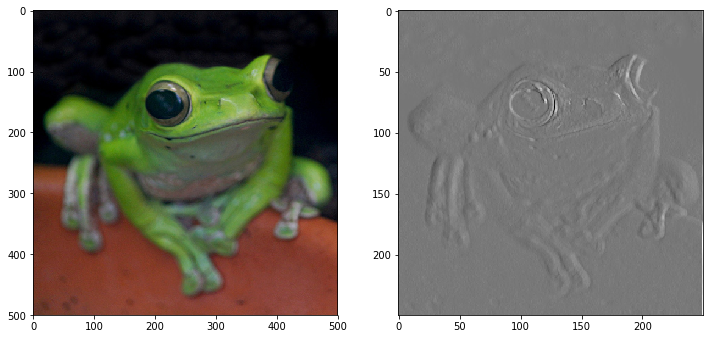

In [144]:
plt.subplot(1, 2, 1)
plt.imshow(rgb_test)
plt.subplot(1, 2, 2)
plt.imshow((mpo - mpo.min()) / (mpo.max() - mpo.min() + 1e-6))
plt.show()

# Trénování konvoluční sítě v PyTorch

Trénování sítě s konvolučními vrstvami bude probíhat úplně stejně jako v minulých cvičeních, tj. metodou SGD. Jediným rozdílem, který je však k celé proceduře transparentní, bude jiná architektura sítě, která bude mít místo lineárních vrstev i konvoluční.

Dále již tedy jen s velmi stručnými komentáři, protože v principu se od minula nic nemění.

## Načtení CIFAR10

In [146]:
from torchvision import datasets
from torchvision import transforms

In [147]:
trainset = datasets.CIFAR10(root='./data', train=True, download=True)
testset = datasets.CIFAR10(root='./data', train=False, download=True)

X_train = trainset.train_data
y_train = np.array(trainset.train_labels, dtype=np.int64)
X_test = testset.test_data
y_test = np.array(testset.test_labels, dtype=np.int64)

print(type(X_train), X_train.shape, X_train.dtype)
print(type(y_train), y_train.shape, y_train.dtype)
print(type(X_test), X_test.shape, X_test.dtype)
print(type(y_test), y_test.shape, y_test.dtype)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_train, num_test = X_train.shape[0], X_train.shape[0]
x_dim = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]

Files already downloaded and verified
Files already downloaded and verified
<class 'numpy.ndarray'> (50000, 32, 32, 3) uint8
<class 'numpy.ndarray'> (50000,) int64
<class 'numpy.ndarray'> (10000, 32, 32, 3) uint8
<class 'numpy.ndarray'> (10000,) int64


In [213]:
print((X_train[0].shape))

(32, 32, 3)


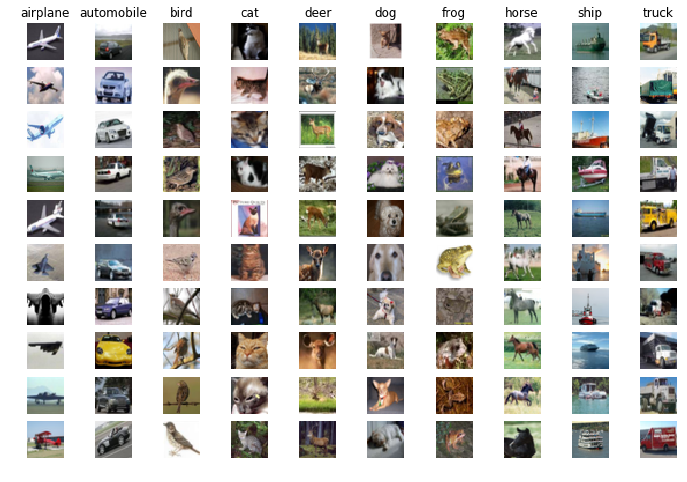

In [148]:
for i, cls in enumerate(classes):
    cls_ids, = np.where(y_train == i)
    draw_ids = np.random.choice(cls_ids, size=10)
    
    for j, k in enumerate(draw_ids):
        plt.subplot(10, 10, j * 10 + i + 1)
        plt.imshow(X_train[k])
        plt.axis('off')
        if j == 0:
            plt.title(cls)
plt.show()

## Preprocessing



In [244]:
def preprocess(rgb_batch, resize=None):
    if isinstance(resize, tuple):
        rgb_batch = [cv2.resize(rgb, (32, 32)) for rgb in rgb_batch]
    X = np.array(rgb_batch, dtype=np.float32) / 255.
    m = np.mean(X, axis=(1, 2))
    X -= m[:, None, None, :]
    
    # pracujeme s obrazky --> je nutne transponovat na torch format
    X = X.transpose(0, 3, 1, 2)
    return X

## Definice konvoluční sítě

In [275]:
CUDA = False

In [293]:
class ConvNet(nn.Module):
    def __init__(self, input_shape=X_train.shape[1:3], output_dim=len(classes)):
        super().__init__()
        
        h, w = input_shape
        
        # definice konvolucni vrstvy
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        
        # prvni vrstva udelana tak, aby zachovala xy rozmery (padding=1)
        # po vrstve ve forward metode aplikujeme 2d max pooling
        # linearni proto bude mit vstup velky `h/2 * w/2 * 32`
        # vystup (pocet skrytych bunek) si zvolime 200
        self.fc2 = nn.Linear(h // 2 * w // 2 * 32, 200)
        
        # posledni klasifikacni vrstva
        self.fc3 = nn.Linear(200, output_dim)
        
        if CUDA:
            self.cuda()
    
    def forward(self, x):
        # konvolucni vrstva <-- toto je tu od minula navic
        z = F.relu(self.conv1(x))
        
        # max pooling s velikosti okna a krokem 2
        z = F.max_pool2d(z, 2)
        
        # z je nyni 64-kanalovy obrazek; pro pouziti a klasifikaci
        # linearni vrstvou prevedeme na vektor
        z = z.view(z.shape[0], -1)
        
        # jako minule, dve linearni vrstvy, mezi kterymi je ReLU
        z = F.relu(self.fc2(z))
        z = self.fc3(z)
        
        return z

In [294]:
convnet = ConvNet()

cnn_history = []

TypeError: torch.FloatTensor constructor received an invalid combination of arguments - got (int, float), but expected one of:
 * no arguments
 * (int ...)
      didn't match because some of the arguments have invalid types: (!int!, !float!)
 * (torch.FloatTensor viewed_tensor)
 * (torch.Size size)
 * (torch.FloatStorage data)
 * (Sequence data)


In [187]:
print(convnet)

ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc2): Linear(in_features=8192, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
)


In [188]:
for name, par in convnet.named_parameters():
    print(name, par.shape, par.numel())

conv1.weight torch.Size([16, 3, 3, 3]) 432
conv1.bias torch.Size([16]) 16
fc2.weight torch.Size([200, 8192]) 1638400
fc2.bias torch.Size([200]) 200
fc3.weight torch.Size([10, 200]) 2000
fc3.bias torch.Size([10]) 10


Všimněme si počtu parametrů v konvoluční vrstvě v porovnání s lineární. Toto je jeden z důvodů, proč se lineární vrstvy označují jako fully connected, jelikož každá z výstupních buněk je napojena na každou ze vstupních. To pak samozřejmě vede na velký počet spojení (=vah). Počet parametrů konvoluce závisí pouze na velikosti a počtu filtrů a na počtu kanálů vstupu, nikoliv však na velikosti v $x$ a $y$ směrech. Váhy jsou při projíždění orbázku sdílené a proto je parametrů mnohem méně.

### Trénování a validace

In [278]:
def train(model, loss_func, optimizer, X_data, y_data, prep_fn=None, batch_size=20, history_output=None, num_iters=None,
          print_every=500, permute=True):
    #COPY PASTE z predchoziho cviceni + edit
    
    """
    Trenovani dopredneho modelu metodou minibatch SGD
    
    vstup:
        model     ... objekt tridy Layer; musi implementovat metody forward a backward
        loss_func ... funkce pocitajici hodnotu kriteria - prijima skore a labely y,
                      vraci loss + gradient na skore (dscore)
        X_data    ... N x D matice trenovacich dat
        y_data    ... N vektor labelu (int)
        num_iters ... pokud None, pak se dopocita automaticky tak, aby jedno zavolani fce = jedna epocha
    """
    
    # V minulem cviceni jsme vybirali vzorky do batche nahodne s opakovanim,
    # neboli behem jedne epochy se mohly nektere obrazky opakovat, zatimco
    # na jine se vubec nedostalo. Zde budeme prochazet obrazky opet v nahodnem
    # poradi, ovsem tak, ze za jednu epochu uvidime kazdy obrazek prave jednou.
    # Toho docilime tak, ze data pred pruchodem nahodne zprehazime.
    if permute:
        perm = np.random.permutation(X_data.shape[0])
    else:
        perm = np.arange(X_data.shape[0], dtype=np.int)
    
    if num_iters is None:
        num_iters = X_data.shape[0] // batch_size

    for n in range(num_iters):
        # nacti dalsi batch
        batch_ids = perm[n * batch_size:(n + 1) * batch_size]
        x = preprocess(X_data[batch_ids], resize=(32, 32))
        x = Variable(torch.from_numpy(x))
        y = y_data[batch_ids]
        
        #################################################################
        # dopredny pruchod
        #####################
        
        if CUDA:
            x = x.cuda()
    
        score = model.forward(x.float())
        """
        #################################################################
        # softmax cross entropy
        #####################
        loss, dscore = loss_func(score,y)
        loss_history.append(np.sum(loss))
        """
        
        #################################################################
        # vyhodnotime presnost
        #####################
        picture_score_class = list()
        for sp in score:
            picture_score_class.append(np.argmax(sp))
            
        acc_pos = 0
        for i in range(0 , len(picture_score_class)):
            if picture_score_class[i] == y[i]:
                acc_pos += 1
        acc = acc_pos/len(picture_score_class)
       
        acc_history.append(acc)

In [265]:
def validate(model, X_data, y_data, prep_fn=None, batch_size=20, history_output=None, print_every=100):
    
    #COPY Paste y predchoziho cviceni
    """
    Validace modelu
    
    vstup:
        model     ... objekt tridy Layer; musi implementovat metody forward a backward
        X_data    ... N x D matice trenovacich dat
        y_data    ... N vektor labelu (int)
    """
    
    num_correct = 0
    
    for n in range(X_data.shape[0]):   
        # ziskame data (jeden vzorek)
        xn = preprocess(X_data[None, n])
        yn = y_data[n]

        # pouze dopredny pruchod
        # pozn.: funkce upravena pro minibatche, ale xn je zde pouze jeden vektor,
        # musime proto pridat jednu dimenzi navic --> minibatch o velikosti 1
        score = model.forward(xn[None, ...])
        
        pred = score.argmax()
        if pred == yn:
            num_correct += 1
        
        # cas od casu vypis, jak se dari
        if (n + 1) % print_every == 0:
            print('{}/{}: acc={:.3f}'.format(n + 1, X_data.shape[0], num_correct / (n + 1)))

    print('val accuracy: {}/{} = {:.1f} %'.format(num_correct, X_data.shape[0], 100. * num_correct / X_data.shape[0]))

In [266]:
def plot_history(history):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    plt.figure(figsize=(10, 3))
    for mi, metric in enumerate(('loss', 'acc')):
        plt.subplot(1, 2, mi + 1)
        
        last = 0.
        trn_data, val_data = [], []
        for h in history:
            trn_data.append(np.mean(h[metric]))
            val_data.append(np.mean(h['val_' + metric]) if h.get('val_' + metric) else last)
            last = val_data[-1]
        
        plt.plot(trn_data)
        plt.plot(val_data)
        
        plt.ylabel(metric)
    
    plt.show()

In [267]:
from torch import optim

In [268]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(convnet.parameters(), lr=0.01)
conv_lazer = ConvNet()

In [279]:
%%time
for ep in range(10):
    train(conv_lazer, loss_func, optimizer, X_train, y_train, print_every=2000)
    
    #Nefunguje to, nevim proc a nevim co s tim 
    validate(conv_lazer, X_train, y_train, print_every=2000)

RuntimeError: Expected object of type torch.FloatTensor but found type torch.cuda.FloatTensor for argument #2 'weight'

In [ ]:
plot_history(cnn_history)

# Predikce

In [286]:
def predict_and_show(model, rgb):
    x = preprocess([rgb], resize=(32, 32))
    x = Variable(torch.from_numpy(x))
    if CUDA:
        x = x.cuda()
    else:
        x = x.float()
    score = model(x).data.cpu().numpy().ravel()
    prob = np.exp(score) / np.sum(np.exp(score))
            
    plt.figure(figsize=(5, 5))
    plt.imshow(rgb)
    ids = np.argsort(-score)
    for i, ci in enumerate(ids):
        plt.gcf().text(1., 0.8 - 0.075 * i, '{}: {:.2f} %'.format(classes[ci], 100. * prob[ci]), fontsize=24)
    plt.subplots_adjust()
    plt.show()
    
    return ids[0]

In [287]:
predict_and_show(convnet, np.array(img))

RuntimeError: Expected object of type torch.FloatTensor but found type torch.cuda.FloatTensor for argument #2 'weight'

# Trénování konvoluční sítě

Zde je opět prostor pro vaši kreativitu. Natrénujte co nejlepší konvoluční síť, která dosáhne max. možného skóre. Kdo si trochu pohraje, měl by se dostat i přes 80&nbsp;%. Min. validační skóre pro uznání úlohy je 60&nbsp;%.